<a href="https://colab.research.google.com/github/arjan-hada/protein-design-vae/blob/main/protein_design_vae_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seqlike biopython torcheval -q miniminiai datasets

# Filling the gaps in protein evolution using Variational Autoencoders
Generative, unsupervised latent variable model for protein sequences

Imagine this: you're at the forefront of computational biology, wielding variational autoencoders (VAEs) to not just decipher but innovate the language of proteins. Each amino acid, a letter; each sequence, a life-defining sentence. Here’s the essence:

1. **Protein Encoder**: Like a diligent scholar, VAE learns from aligned protein sequences, and distills them into multidimensional latent space. This latent space captures the essential information about the protein sequence.

2. **Latent Space**: Within this latent realm, the VAE, akin to an explorer, identifies the underlying biological patterns in existing protein sequences.

3. **Decoder**: Given a point in the latent space identified as potentially interesting (e.g., representing a stable protein), the decoder translates this point back into a new protein sequence. This creates novel sequences with a higher likelihood of possessing the desired properties.

VAE marries the predictive power of machine learning with the creative potential of synthetic biology. It has the potential to accelerate the discovery of therapeutic proteins and enzymes with enhanced catalytic properties.

## The data: Multiple Sequence Alignment

In [2]:
# Import libraries
from seqlike import aaSeqLike
from seqlike.alphabets import AA
from Bio import SeqIO
import pandas as pd
import multiprocessing as mp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
import torch.optim as optim
from torch.optim import lr_scheduler
from miniminiai import *
from fastai.callback.training import GradientClip
import fastcore.all as fc
from functools import partial

/usr/local/lib/python3.10/dist-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [ ]:
import random
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
torch.manual_seed(1)
set_seed(42)

In [3]:
!mkdir -p data

In [4]:
!wget -O data/tr-B5LY47-B5LY47-ECOLX_blast_nr_5000_aligned.fasta https://raw.githubusercontent.com/modernatx/therapeutic_enzyme_engineering_with_generative_neural_networks/main/data/tr-B5LY47-B5LY47-ECOLX_blast_nr_5000_aligned.fasta

--2024-03-11 21:40:10--  https://raw.githubusercontent.com/modernatx/therapeutic_enzyme_engineering_with_generative_neural_networks/main/data/tr-B5LY47-B5LY47-ECOLX_blast_nr_5000_aligned.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2486624 (2.4M) [text/plain]
Saving to: ‘data/tr-B5LY47-B5LY47-ECOLX_blast_nr_5000_aligned.fasta’

data/tr-B5LY47-B5LY 100%[===================>]   2.37M  --.-KB/s    in 0.009s  

2024-03-11 21:40:10 (267 MB/s) - ‘data/tr-B5LY47-B5LY47-ECOLX_blast_nr_5000_aligned.fasta’ saved [2486624/2486624]



In [5]:
!head data/tr-B5LY47-B5LY47-ECOLX_blast_nr_5000_aligned.fasta

>tr|B5LY47|B5LY47_ECOLX Beta-lactamase (Fragment) OS=Escherichia coli OX=562 PE=1 SV=1
-------AACI-PLLLGSAPLYA---QT------SA------VQ-Q------KLAALEKS
SGGRLGVALIDTADNTQVLYRGDERFPMC-STSKVMAAAAVLKQSETQKQLLNQPVEIKP
ADL--VNYNPIAEKHVNGTMTLAELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGD
ETFRLDRTEPTLNTAIPG-DPRDTTTPRAMAQTLRQLTLGHA-LGETQRAQLVTWLKGNT
TGAASIRAGLPTSWTVGDKTGSGGYGTTNDIAVIW-PQGRAPLVLVTYF----TQ-----
-PQQNAESRRDVLASAARIIAEGL
>gb|QGJ84174.1| CTX-M family beta-lactamase, partial [Escherichia coli] >gb|QGJ84176.1| CTX-M family beta-lactamase, partial [Escherichia coli] >gb|QGJ84177.1| CTX-M family beta-lactamase, partial [Escherichia coli] 1 seqs
-------AACI-PLLLGSAPLYA---QT------SA------VQ-Q------KLAALEKS
SGGRLGVALIDTADNTQVLYRGDERFPMC-STSKVMAAAAVLKQSETQKQLLNQPVEIKP


In [6]:
input_file = "data/tr-B5LY47-B5LY47-ECOLX_blast_nr_5000_aligned.fasta"

In [7]:
seqs = pd.Series([aaSeqLike(s, alphabet=AA)
for s in SeqIO.parse(input_file, "fasta")])
seqs = pd.Series([x for x in seqs if "B" not in x and "X" not in x])

In [8]:
seqs.sample(10).seq.plot()

GridPlot(id='p1073', ...)

We are starting from a set of meaningful protein sequences from multiple sequence alignment, and we hope to train a model to reproduce them with some novelty. Leveraging Multiple Sequence Alignments (MSAs) for generative model training offers advantages:

1. **Handling Sequence Length Variation:** MSAs effectively address the challenge of **sequences with different lengths**. Gap characters within the alignment accommodate variations, allowing the model to learn from sequences of varying sizes.

2. **Capturing Evolutionary Relationships:** MSAs go beyond simply aligning sequences. They capture the **evolutionary relationships** between a group of protein sequences. This is achieved by:

    - **Explicit Information:** MSAs explicitly capture **position-wise amino acid frequencies**. This reveals how **conserved** (important) each residue appears to be at a specific position in the protein.

    - **Implicit Information:** While not directly encoded, MSAs also implicitly capture **correlations between positions**. These correlations represent the interdependence of amino acids at different locations within the protein structure, a key aspect not captured by models that solely rely on position-wise frequencies.

By incorporating both explicit and implicit information from MSAs, generative models can learn more nuanced relationships between protein sequences and generate novel sequences that are not only structurally feasible but also potentially retain important functional features.

## Datasets and Dataloaders

In [9]:
class ProteinDataset(Dataset):
    """Creates a custom dataset to handle protein sequences represented as SeqLikes."""

    def __init__(self, seq_series):
        self.seq_series = seq_series
        self.xl = torch.tensor(seq_series.seq.to_onehot()).float().unsqueeze(1)
        self.yl = self.xl.clone()

    def __len__(self):
        """Returns the number of sequences in the dataset."""
        return len(self.seq_series)

    def __getitem__(self, index):
        """Returns the sequence at the specified index."""
        return self.xl[index, :], self.yl[index, :]

In [10]:
ds= ProteinDataset(seqs)
print(len(ds))

4987


Notice that `class ProteinDataset(Dataset)` utilizes the input protein sequence as both the input and target during training.

In [11]:
train_size = int(len(ds) * 0.8)
val_size = len(ds) - train_size
train_ds, val_ds = random_split(ds, [train_size, val_size])

bs = 128
train_dl, val_dl = get_dls(train_ds, val_ds, bs=bs)

# Turn it into dls
dls = DataLoaders(train_dl, val_dl)

In [12]:
# Look at the data
xb, yb = next(iter(dls.train))
print(xb.shape)
print(yb.shape)
print(yb[0])

torch.Size([128, 1, 324, 28])
torch.Size([128, 1, 324, 28])
tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]]])


## Model

Our model is a Variational Autoencoder (VAE) designed for protein sequence design. The VAE operates by first encoding an input protein sequence into a lower-dimensional latent representation, denoted as 'z'. This 'z' is not a single value, but rather a pair of vectors: the mean and standard deviation of a normal distribution. This approach allows the model to capture the essential features of the protein sequence in a compressed format while also accounting for the inherent variability observed in protein sequences. Subsequently, the VAE can sample from this learned distribution to generate new protein sequences. This sampling process enables the model to create novel protein sequences that share similar characteristics with the training data. For a tutorial on VAE see [this video](https://www.youtube.com/watch?v=9zKuYvjFFS8).

**Walks through different steps as I prototype the code, rather than final consolidated implementation.**

In [13]:
seq_len = len(seqs[0])
alphabet_sz = len(AA)
ni,nh1,nh2,nh3,nl = 1, 256, 128, 64, 64

In [14]:
def enc_conv(ni, nf, norm=nn.BatchNorm2d, act=nn.SiLU):
    layers = nn.Sequential(nn.Conv2d(ni, nf, kernel_size=(3, 3),
                                     stride=(2, 1),
                                     padding=1,
                                     dilation=1))
    if norm: layers.append(norm(nf))
    if act : layers.append(act())
    return layers

In [15]:
out1 = enc_conv(ni, nh1)(xb)
print(out1.shape)
out2 = enc_conv(nh1, nh2)(out1)
print(out2.shape)
out3 = enc_conv(nh2, nh3)(out2)
print(out3.shape)
out4 = nn.Flatten()(out3)
print(out4.shape)

torch.Size([128, 256, 162, 28])
torch.Size([128, 128, 81, 28])
torch.Size([128, 64, 41, 28])
torch.Size([128, 73472])


In [16]:
def eff_seq_len(ht_in, n, kernel_size, stride, padding, dilation):
    """
    Calculate the effective sequence length after convolution.
    """

    hts = []  # Store heights after each convolution
    ht_curr = ht_in

    for _ in range(n):
        ht_curr = ((ht_curr + 2*padding - dilation*(kernel_size - 1) - 1) // stride) + 1
        hts.append(ht_curr)

    return hts

In [17]:
eff_seq_lens = eff_seq_len(seq_len, 3, 3, 2, 1, 1)
eff_seq_lens

[162, 81, 41]

In [18]:
def lin(ni, nf, act=nn.SiLU, bias=True):
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act : layers.append(act())
    return layers

In [19]:
class VAEEncoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.convs = nn.Sequential(
            enc_conv(ni , nh1),
            enc_conv(nh1, nh2),
            enc_conv(nh2, nh3),
            nn.Flatten())

        encoded_sz = nh3 * eff_seq_lens[-1] * alphabet_sz
        self.fc_mu = lin(encoded_sz, nl, act=None)
        self.fc_logvar = lin(encoded_sz, nl, act=None)

    def forward(self, x):
        x = self.convs(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [20]:
encoder = VAEEncoder()
mu, logvar = encoder(xb)
mu.shape, logvar.shape

(torch.Size([128, 64]), torch.Size([128, 64]))

In [21]:
def decode_conv(ni, nf, ht_pad=0, norm=nn.BatchNorm2d, act=nn.SiLU):
    layers = nn.Sequential(nn.ConvTranspose2d(ni, nf, kernel_size=(3, 3),
                                              stride = (2, 1),
                                              padding=1,
                                              output_padding=(ht_pad,0),
                                              dilation=1))
    if norm: layers.append(norm(nf))
    if act : layers.append(act())
    return layers

In [22]:
out1 = lin(nl, nh3 * eff_seq_lens[-1] * alphabet_sz)(mu)
print(out1.shape)
out2 = nn.Unflatten(1, (nh3, eff_seq_lens[-1], alphabet_sz))(out1)
print(out2.shape)
out3 = decode_conv(nh3, nh2)(out2)
print(out3.shape)
out4 = decode_conv(nh2, nh1)(out3)
print(out4.shape)
out5 = decode_conv(nh1, ni, norm=None, act=None)(out4)
print(out5.shape)
out = nn.Softmax(dim=3)(out5)
print(out5.shape)

torch.Size([128, 73472])
torch.Size([128, 64, 41, 28])
torch.Size([128, 128, 81, 28])
torch.Size([128, 256, 161, 28])
torch.Size([128, 1, 321, 28])
torch.Size([128, 1, 321, 28])


In [23]:
expected_seq_lens = list(reversed(eff_seq_lens[:-1])) + [seq_len]
expected_seq_lens

[81, 162, 324]

In [24]:
def cal_out_pad(inp_szs, out_szs, kernel_size, stride, padding, dilation):
    """
    Calculate the required output padding for a series of layers to achieve specific target output sizes.

    Parameters:
    - inp_szs: List of input sizes for each layer.
    - out_szs: List of target output sizes for each layer.

    Returns:
    - List of output paddings required for each layer.
    """
    out_pads = []

    for inp_sz, out_sz in zip(inp_szs, out_szs):
        output_padding = out_sz - ((stride * (inp_sz - 1) + dilation * (kernel_size - 1) + 1 - 2 * padding))
        out_pads.append(output_padding)

    return out_pads

In [25]:
out_pads = cal_out_pad(list(reversed(eff_seq_lens)), expected_seq_lens, 3, 2, 1, 1)
out_pads

[0, 1, 1]

In [26]:
out1 = lin(nl, nh3 * eff_seq_lens[-1] * alphabet_sz)(mu)
print(out1.shape)
out2 = nn.Unflatten(1, (nh3, eff_seq_lens[-1], alphabet_sz))(out1)
print(out2.shape)
out3 = decode_conv(nh3, nh2, ht_pad=out_pads[0])(out2)
print(out3.shape)
out4 = decode_conv(nh2, nh1, ht_pad=out_pads[1])(out3)
print(out4.shape)
out5 = decode_conv(nh1, ni, ht_pad=out_pads[2], norm=None, act=None)(out4)
print(out5.shape)
out = nn.Softmax(dim=3)(out5)
print(out5.shape)

torch.Size([128, 73472])
torch.Size([128, 64, 41, 28])
torch.Size([128, 128, 81, 28])
torch.Size([128, 256, 162, 28])
torch.Size([128, 1, 324, 28])
torch.Size([128, 1, 324, 28])


In [27]:
class VAEDecoder(nn.Module):
    """Decoder network for VAE protein sequence design."""

    def __init__(self):
        super().__init__()

        encoded_sz = nh3 * eff_seq_lens[-1] * alphabet_sz

        self.layers = nn.Sequential(
            lin(nl, encoded_sz),
            nn.Unflatten(1, (nh3, eff_seq_lens[-1], alphabet_sz)),
            decode_conv(nh3, nh2, ht_pad=out_pads[0]),
            decode_conv(nh2, nh1, ht_pad=out_pads[1]),
            decode_conv(nh1, ni, ht_pad=out_pads[2], norm=None, act=None),
            nn.Softmax(dim=3)
            )

    def forward(self, z):
        x = self.layers(z)
        return x

In [28]:
decoder = VAEDecoder()
decoder(mu).shape

torch.Size([128, 1, 324, 28])

In [29]:
def init_weights(m, leaky=0.):
    """
    Initializes weights of convolutional and linear layers using Kaiming/He normalization.

    Parameters:
    - m: A module or layer of a PyTorch model.
    - leaky: The negative slope of the leaky ReLU activation applied after the layer.
             This parameter is used to adjust the Kaiming initialization accordingly.
             For regular ReLU, keep it at 0. For leaky ReLU, set it to the value of the negative slope.
    """
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        init.kaiming_normal_(m.weight, a=leaky)

Kaiming (He) initialization strategy designed to **preserve the variance of the inputs** through the layers of the network,
a property that is beneficial for maintaining effective gradient flow during training.

In [30]:
iw = partial(init_weights, leaky=0.2)

In [31]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()
        iw(self)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

The VAE's `forward` method encodes an input protein, samples a latent representation ('z'), and decodes it back to a new protein. During training, we return both the reconstructed protein and the latent distribution's mean and standard deviation for loss calculation.

In [32]:
m = VAE()
m

VAE(
  (encoder): VAEEncoder(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (1): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (2): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (3): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Sequential(
      (0): Linear(in_features=73472, out_features=64, bias=True)
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=73472, out_features=64, bias=True)
    )
  )
  (decoder): VAEDecod

In [33]:
result = m(xb)

reconstruction, mean, logvar = result

reconstruction.shape, mean.shape, logvar.shape

(torch.Size([128, 1, 324, 28]), torch.Size([128, 64]), torch.Size([128, 64]))

## The Learner

### VAE Loss

We have two terms in our VAE loss function. Reconstruction loss measures how well the model has reconstructed the protein from 'z', and the KL Divergence is there to force the VAE to learn a distribution that is close to a standard normal distribution. This is a regularizer that helps the model to learn meaningful representations, so that (if all goes well) we can later use it to generate new proteins

In [34]:
def kld_loss(inp, x):  # KL Divergence
    x_hat, mu, logvar = inp
    return -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

def bce_loss(inp, x):  # Reconstruction loss
    return F.binary_cross_entropy_with_logits(inp[0], x)

def vae_loss(inp, x): return kld_loss(inp, x) + bce_loss(inp, x)

In [35]:
vae_loss(result, xb)

tensor(0.8070, grad_fn=<AddBackward0>)

In [36]:
class FuncMetric(Mean):
    """Compute the mean of any function (`fn`) applied to inputs and targets over all updates"""
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn

    def update(self, inp, targets):
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

In [37]:
metrics = MetricsCB(kld=FuncMetric(kld_loss), bce=FuncMetric(bce_loss))

# Define the optimizer
opt_func = partial(optim.Adam, eps=1e-5)

### Functions for training quality plots

Functions required to define `Activationstats` callback that record the mean, standard deviation, and histogram of activations of every trainable layer. This allows us to look inside our models while they're training. Think of this as quality plots from training process we can use to find ways to make our model train better.

Code from: https://github.com/fastai/minai/blob/main/core.ipynb

In [38]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp).float()
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

In [39]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

In [40]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

In [41]:
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [42]:
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [43]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [44]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

### Learning rate finder

`Learner` class from super-duper awesome [fastai](https://github.com/fastai/course22p2/blob/master/nbs/29_vae.ipynb).

In [45]:
torch.cuda.is_available()

True

In [46]:
torch.backends.cudnn.enabled

True

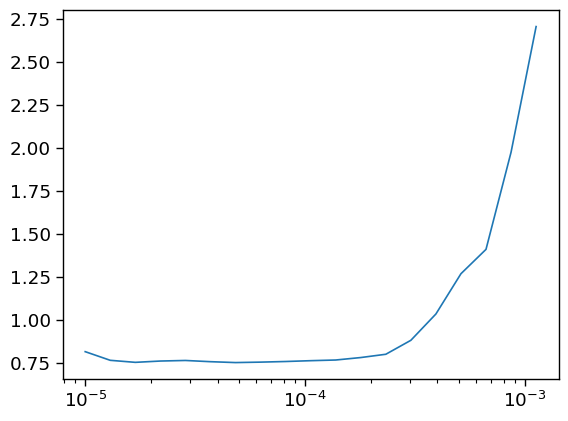

In [47]:
lrf_cbs = [TrainCB(), DeviceCB(), metrics]
model = VAE()
learn = Learner(model, dls, vae_loss, lr=0.1, cbs=lrf_cbs, opt_func=opt_func)
learn.lr_find()

#### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [48]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

In [49]:
lr = 1e-4
epochs = 50
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
astats = ActivationStats(fc.risinstance(nn.Conv2d))


cbs = [DeviceCB(), # Handles making sure data and model are on the right device
       ProgressCB(plot=True), # Displays metrics and loss during training
       metrics, # Keep track of any relevant metrics
       BatchSchedCB(sched),
       GradientClip, # Prevents exploding gradients
       MixedPrecision(),
       rec,
       astats] # Keep track of metrics

# Define the model
model = VAE()
learn = Learner(model, dls, vae_loss, lr=lr, cbs=cbs, opt_func=opt_func)

kld,bce,loss,epoch,train
0.031,0.712,0.743,0,train
0.007,0.710,0.717,0,eval
0.012,0.712,0.724,1,train
0.007,0.711,0.719,1,eval
0.007,0.711,0.718,2,train
0.006,0.711,0.717,2,eval
0.004,0.711,0.715,3,train
0.004,0.710,0.714,3,eval
0.003,0.709,0.712,4,train
0.003,0.708,0.711,4,eval


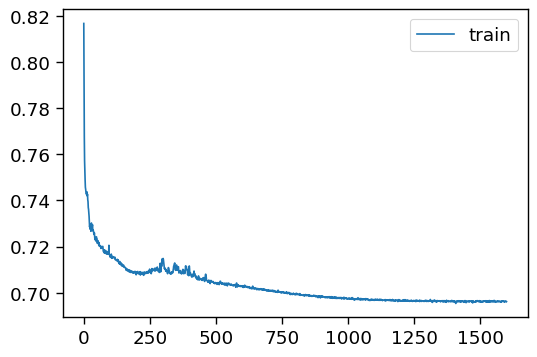

In [50]:
learn.fit(epochs)

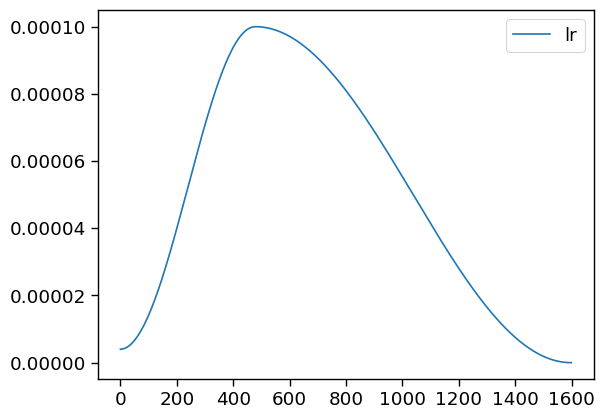

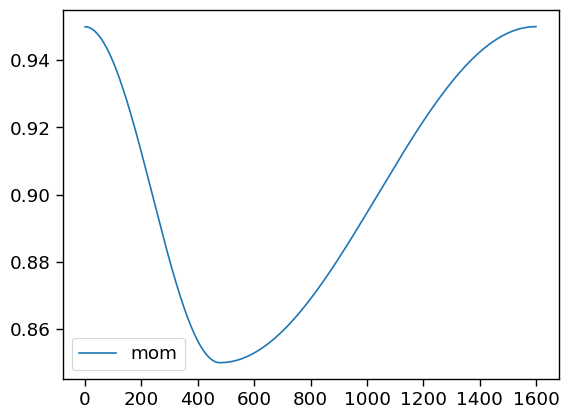

In [54]:
rec.plot()

In [51]:
plt.rc('image', cmap='viridis')
astats.color_dim()

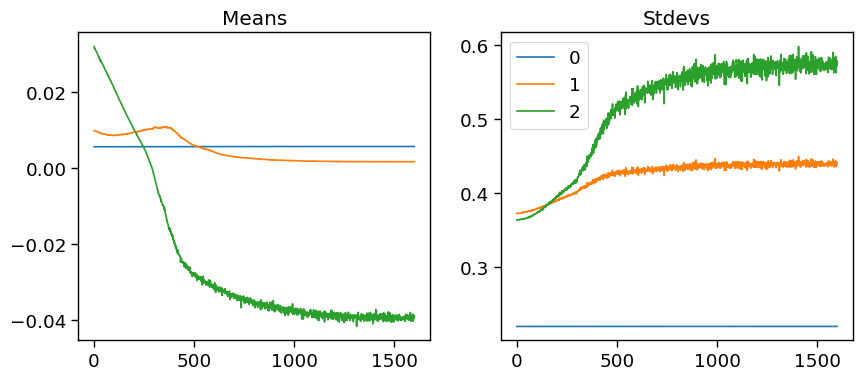

In [52]:
astats.plot_stats()

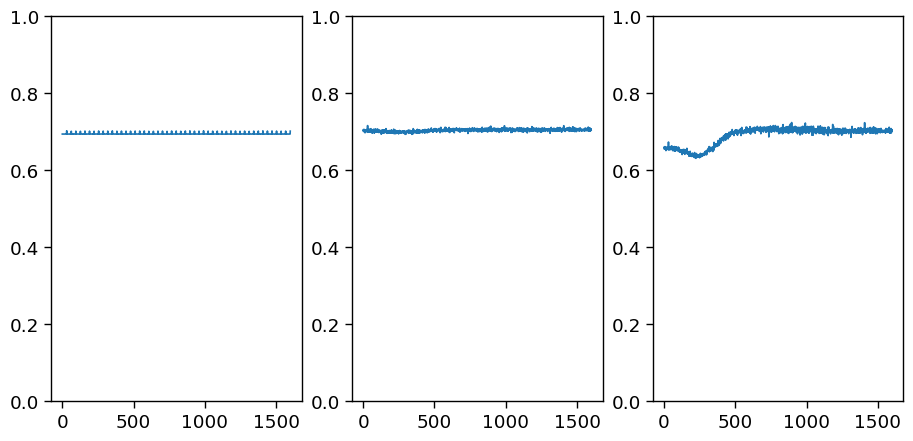

In [53]:
astats.dead_chart()

## VAE Sample

In [55]:
with torch.no_grad(): recon,mu,logvar = to_cpu(model(xb.cuda()))
recon = recon.float()

In [56]:
print(AA)
print(aaSeqLike(AA, alphabet=AA).to_index())

*-ACDEFGHIKLMNPQRSTVWYXBJOUZ
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


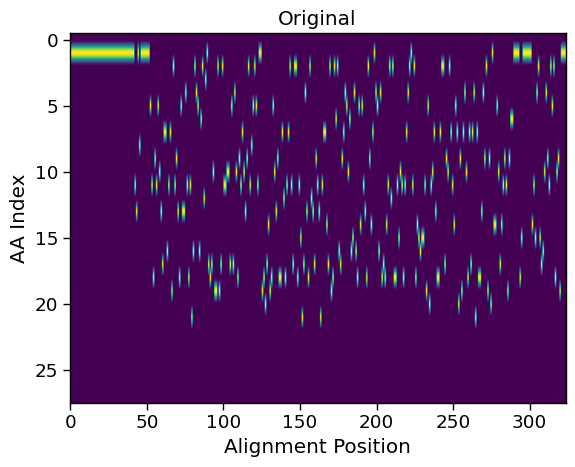

In [57]:
plt.imshow(xb[0].cpu().squeeze().T, vmax=1, vmin=0)
plt.axis("tight")
plt.ylabel("AA Index")
plt.xlabel("Alignment Position")
plt.title("Original");

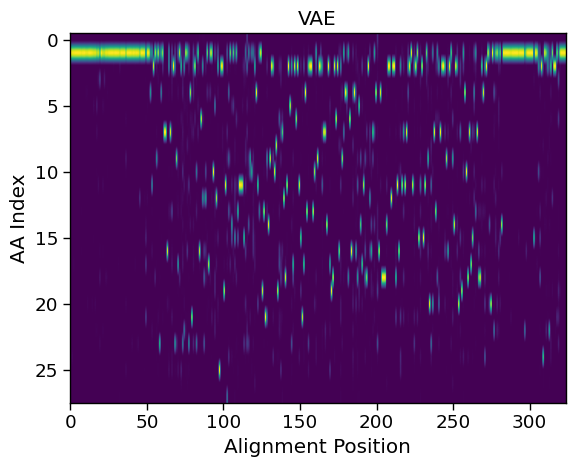

In [58]:
plt.imshow(recon[0].cpu().squeeze().T, vmax=1, vmin=0)
plt.axis("tight")
plt.ylabel("AA Index")
plt.xlabel("Alignment Position")
plt.title("VAE");

In [59]:
recon[0].shape

torch.Size([1, 324, 28])

In [73]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [74]:
torch.save(learn.model, mdl_path/'vae-dev.pkl')

In [75]:
learn.model = torch.load(mdl_path/'vae-dev.pkl')

**Evaluation**:

Evaluate the performance of my modified architecture by comparing generated sequences to a benchmark dataset in terms of diversity metrics (e.g., Shannon entropy) and functional similarity to known proteins.
Visualize the latent space using dimensionality reduction techniques to assess if it captures meaningful relationships between protein sequences.